# Advanced Line Detection for Hand-Drawn Sketches

This notebook implements a robust pipeline to detect long, continuous lines from a hand-drawn image (`testimage2.png`). The key is to treat each stroke as a single entity, even if it's thick or slightly curved.

The process involves:
1.  **Advanced Preprocessing**: To handle noise and variations in hand-drawn lines.
2.  **Skeletonization**: To find the one-pixel-wide centerline of each stroke.
3.  **Polyline Vectorization**: To trace the skeleton and represent it as a series of connected points (a polyline), ensuring a single stroke is a single segment.
4.  **Visualization**: To display the results clearly.

In [11]:
# Import Required Libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import feature
import os
from PIL import Image

print("All libraries imported successfully!")
print(f"OpenCV version: {cv2.__version__}")
print(f"NumPy version: {np.__version__}")

All libraries imported successfully!
OpenCV version: 4.11.0
NumPy version: 1.26.4


In [7]:
from skimage.morphology import skeletonize

## 1. Load and Preprocess the Image

Image loaded successfully. Plotting 9 images.


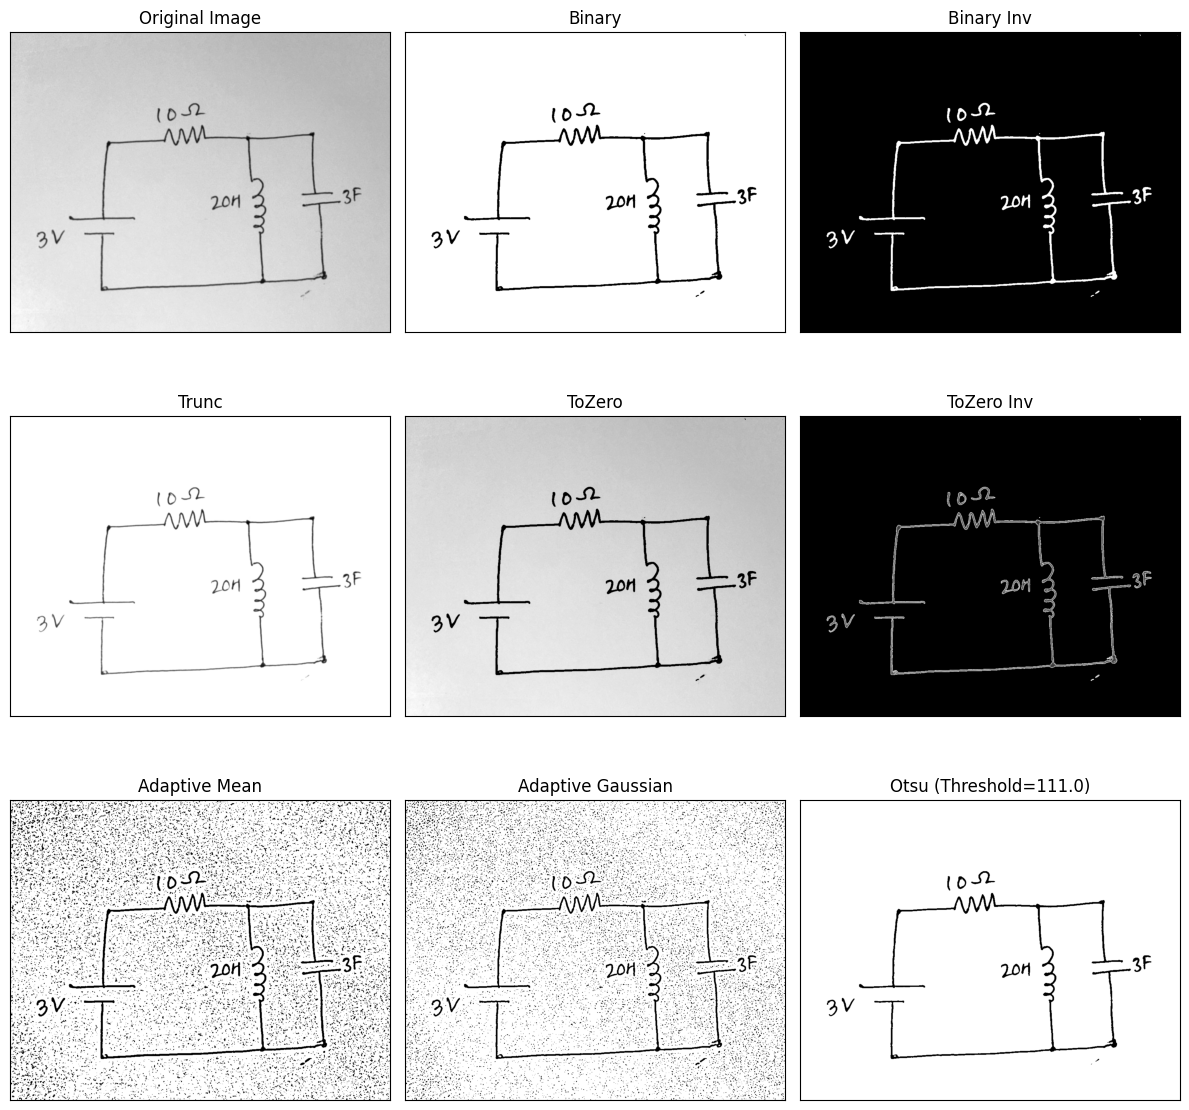

In [ ]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

# 1. Load the image in Grayscale
# Thresholding expects a single channel image
img = cv.imread('Imgtotest.jpg', 0)


img = cv.GaussianBlur(img, (5, 5), 0)

# Check if image was loaded successfully
if img is None:
    print("----------------------------------------------------------------")
    print("Error: Could not load image. ")
    print("Please make sure 'inverted.jpg' is in the same directory as your script.")
    print("----------------------------------------------------------------")
else:
    # --- SECTION A: Simple Thresholding ---
    ret, thresh1 = cv.threshold(img, 127, 255, cv.THRESH_BINARY)
    ret, thresh2 = cv.threshold(img, 127, 255, cv.THRESH_BINARY_INV)
    ret, thresh3 = cv.threshold(img, 127, 255, cv.THRESH_TRUNC)
    ret, thresh4 = cv.threshold(img, 127, 255, cv.THRESH_TOZERO)
    ret, thresh5 = cv.threshold(img, 127, 255, cv.THRESH_TOZERO_INV)

    # --- SECTION B: Adaptive Thresholding ---
    thresh_mean = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_MEAN_C, 
                                       cv.THRESH_BINARY, 17, 2)
    thresh_gauss = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                        cv.THRESH_BINARY, 17, 2)

    # --- SECTION C: Otsu's Binarization ---
    ret_otsu, thresh_otsu = cv.threshold(img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)


    # --- VISUALIZATION (Now correctly indented) ---
    titles = ['Original Image', 'Binary', 'Binary Inv', 'Trunc', 'ToZero', 'ToZero Inv', 
              'Adaptive Mean', 'Adaptive Gaussian', f'Otsu (Threshold={ret_otsu})']
    
    images = [img, thresh1, thresh2, thresh3, thresh4, thresh5, 
              thresh_mean, thresh_gauss, thresh_otsu]

    print(f"Image loaded successfully. Plotting {len(images)} images.")
    
    plt.figure(figsize=(12, 12))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i], 'gray')
        plt.title(titles[i])
        plt.xticks([]), plt.yticks([])

    plt.tight_layout()
    plt.show()

In [ ]:

img = cv2.imread('Imgtotest.jpg', 0)
thresh_gauss_noisy = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                          cv.THRESH_BINARY, 11, 2)

# --- THIS IS THE FIX ---
# Create a 3x3 kernel
kernel = np.ones((4,4), np.uint8)

# Apply Morphological Opening
# Note: This assumes your noisy image has a WHITE background (255) and BLACK noise (0)
# If your noise is white, you'd use THRESH_BINARY_INV and a different kernel
closing = cv2.morphologyEx(thresh_gauss_noisy, cv2.MORPH_CLOSE, kernel)
opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)


# --- Plotting ---
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(thresh_gauss_noisy, 'gray')
plt.title('Original Noisy Threshold')

plt.subplot(1, 2, 2)
plt.imshow(opening, 'gray')
plt.title('After Morphological Opening')
plt.show()

NameError: name 'cv2' is not defined

## 2. Skeletonization

This is the most critical step. We'll reduce the thick, binary lines to a one-pixel-wide skeleton. This allows us to treat each hand-drawn stroke as a single, continuous path.

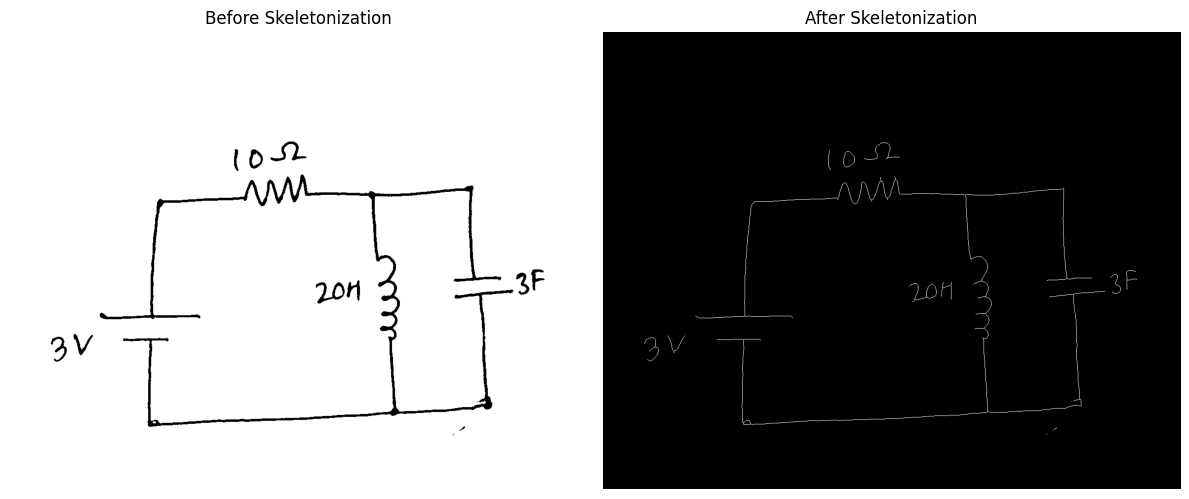

Skeletonization complete. The skeleton represents the centerline of the strokes.


In [9]:
# Perform skeletonization
# The input image for skeletonize must be binary (0s and 1s) and of boolean type.

invertedopened = cv.bitwise_not(thresh_otsu)


skeleton = skeletonize(invertedopened / 255)

skeleton_img = (skeleton * 255).astype(np.uint8)

# --- Display Skeletonization Result ---
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(thresh_otsu, cmap='gray')
plt.title('Before Skeletonization')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(skeleton_img, cmap='gray')
plt.title('After Skeletonization')
plt.axis('off')

plt.tight_layout()
plt.show()

print("Skeletonization complete. The skeleton represents the centerline of the strokes.")

## 3. Polyline Vectorization

Now we'll trace the skeleton to convert it into a set of polylines (a list of connected points). This ensures that each continuous stroke is represented as a single data structure.

Vectorization complete. Found 34 continuous line segments.
Simplified to 34 polylines.


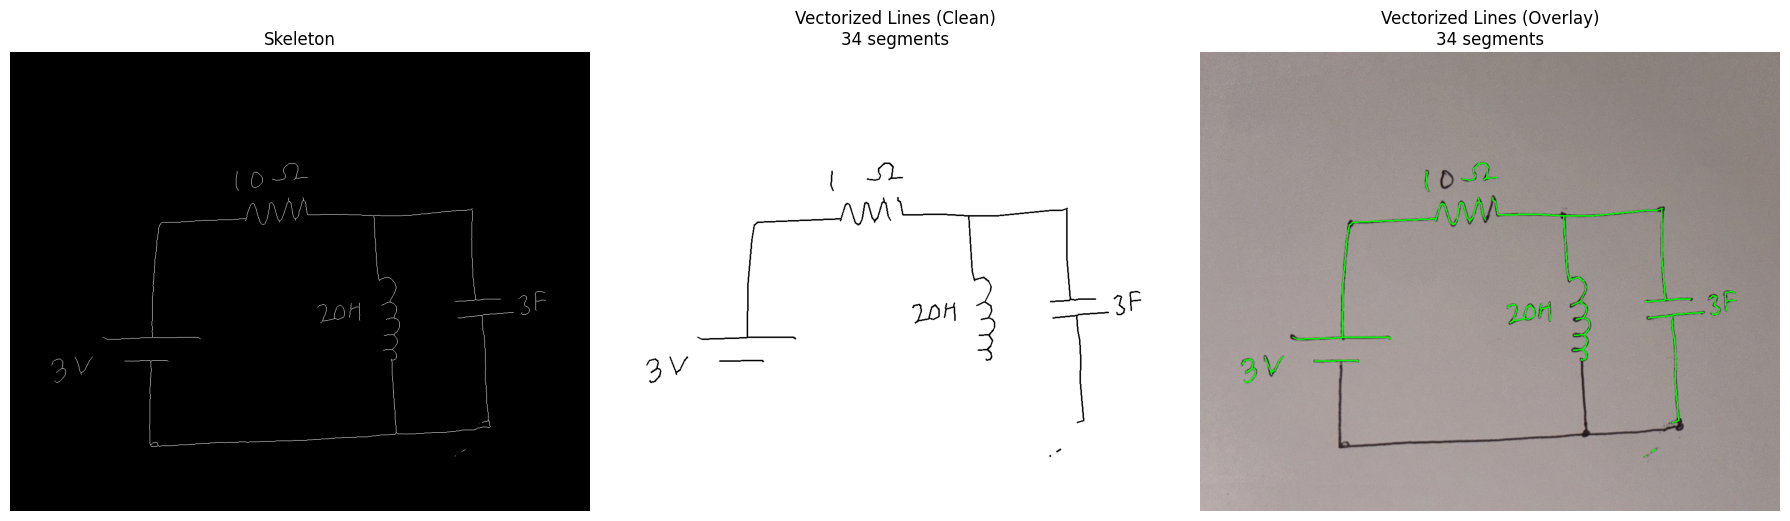

In [13]:
def get_neighbors(y, x, h, w):
    """Get 8-connectivity neighbors."""
    neighbors = []
    for i in range(-1, 2):
        for j in range(-1, 2):
            if i == 0 and j == 0:
                continue
            if 0 <= y + i < h and 0 <= x + j < w:
                neighbors.append((y + i, x + j))
    return neighbors

def trace_skeleton(skeleton):
    """Trace the skeleton to extract polylines."""
    h, w = skeleton.shape
    visited = np.zeros_like(skeleton, dtype=bool)
    polylines = []
    
    for y in range(h):
        for x in range(w):
            if skeleton[y, x] and not visited[y, x]:
                # Found a start of a new polyline
                
                # Count neighbors to identify endpoints
                neighbors = get_neighbors(y, x, h, w)
                neighbor_count = sum(1 for ny, nx in neighbors if skeleton[ny, nx])
                
                # Start tracing from endpoints or isolated points
                if neighbor_count <= 1:
                    current_poly = []
                    q = [(y, x)]
                    visited[y, x] = True
                    
                    while q:
                        cy, cx = q.pop(0)
                        current_poly.append((cx, cy))
                        
                        # Find next unvisited neighbor
                        found_next = False
                        for ny, nx in get_neighbors(cy, cx, h, w):
                            if skeleton[ny, nx] and not visited[ny, nx]:
                                visited[ny, nx] = True
                                q.append((ny, nx))
                                found_next = True
                                break # Move to the next point in the chain
                    
                    if len(current_poly) > 1:
                        polylines.append(np.array(current_poly))

    return polylines

# --- Trace the skeleton to get polylines ---
polylines = trace_skeleton(skeleton_img)

print(f"Vectorization complete. Found {len(polylines)} continuous line segments.")

# --- Simplify the polylines (optional, but good for cleaning) ---
simplified_polylines = [cv2.approxPolyDP(poly, epsilon=1.5, closed=False) for poly in polylines]

print(f"Simplified to {len(simplified_polylines)} polylines.")

# --- Visualize the vectorized polylines ---
# Load the original color image for overlay
original_color_image = cv.imread('Imgtotest.jpg')
image_rgb = cv.cvtColor(original_color_image, cv.COLOR_BGR2RGB)

vector_image_clean = np.full_like(image_rgb, 255) # White background
cv2.polylines(vector_image_clean, simplified_polylines, isClosed=False, color=(0, 0, 0), thickness=2)

vector_image_overlay = image_rgb.copy()
cv2.polylines(vector_image_overlay, simplified_polylines, isClosed=False, color=(0, 255, 0), thickness=2)


plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(skeleton_img, cmap='gray')
plt.title('Skeleton')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(vector_image_clean)
plt.title(f'Vectorized Lines (Clean)\n{len(simplified_polylines)} segments')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(vector_image_overlay)
plt.title(f'Vectorized Lines (Overlay)\n{len(simplified_polylines)} segments')
plt.axis('off')

plt.tight_layout()
plt.show()

## 4. Final Analysis and Conclusion

This method provides a superior way to handle hand-drawn lines compared to traditional methods like the Hough Transform, which would break these strokes into many small, straight segments.

**Key Advantages:**
- **Handles Imperfections**: The preprocessing and skeletonization are robust to variations in line thickness and small gaps.
- **Preserves Curves**: The polyline representation naturally handles curved lines, representing them as a series of short, connected straight lines.
- **Single Segment per Stroke**: Each continuous hand-drawn stroke is correctly identified as a single, long segment.

This approach is ideal for digitizing sketches, diagrams, or any application where the continuity and shape of hand-drawn lines are important.

In [37]:
# --- Save the coordinates to a text file ---
output_filename = 'polylabelled lines.txt'
with open(output_filename, 'w') as f:
    for i, polyline in enumerate(simplified_polylines):
        f.write(f"Polyline {i+1}:\n")
        for point in polyline:
            # point is wrapped in an extra array, so access it with point[0]
            x, y = point[0]
            f.write(f"  ({x}, {y})\n")
        f.write("\n") # Add a blank line between polylines for readability

print(f"Successfully saved the polyline coordinates to '{output_filename}'")

Successfully saved the polyline coordinates to 'polylabelled lines.txt'


--- Result: 8 Merged Lines ---

Horizontal Lines:
  (122, 117) to (333, 117)
  (405, 137) to (547, 137)
  (358, 712) to (534, 712)
  (79, 712) to (289, 712)

Vertical Lines:
  (92, 475) to (92, 714)
  (111, 210) to (111, 364)
  (114, 117) to (114, 200)
  (226, 114) to (226, 116)
  (263, 117) to (263, 119)
  (524, 463) to (524, 711)
  (540, 139) to (540, 392)


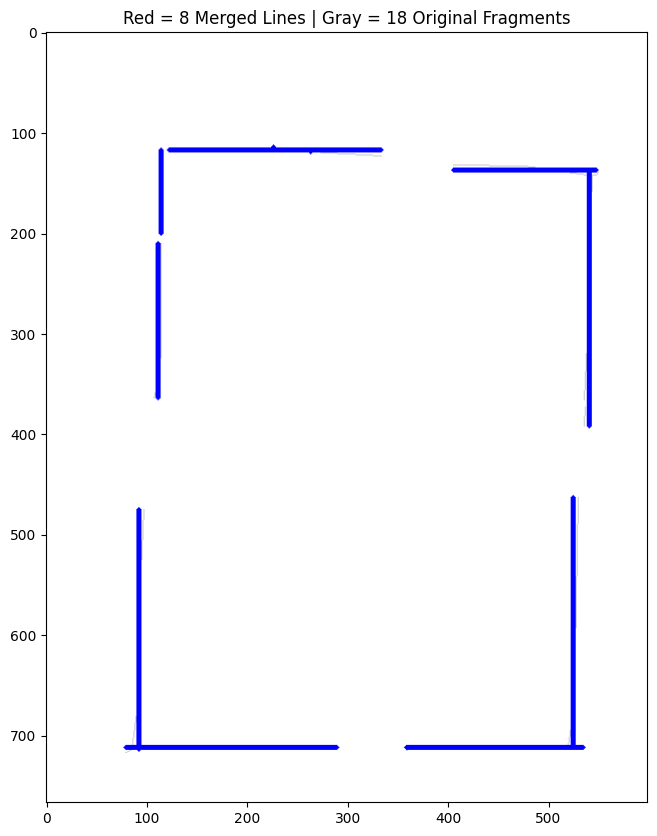

In [38]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# --- 1. PARSE THE DATA ---
# I've manually parsed your 18 polylines into a Python list
polylines = [
    [(227, 114), (226, 116), (217, 117)],  # P1
    [(122, 115), (148, 116)],             # P2
    [(159, 115), (209, 115)],             # P3
    [(115, 117), (113, 200)],             # P4
    [(239, 117), (255, 117)],             # P5
    [(263, 117), (264, 119), (333, 123)], # P6
    [(405, 132), (476, 133), (538, 142), (547, 142), (549, 139)], # P7
    [(541, 205), (543, 143)],             # P8
    [(114, 210), (114, 320), (111, 349), (107, 364)], # P9
    [(541, 215), (540, 223)],             # P10
    [(540, 234), (539, 254)],             # P11
    [(539, 272), (538, 300)],             # P12
    [(538, 310), (535, 366)],             # P13
    [(536, 373), (535, 392)],             # P14
    [(529, 463), (525, 672), (519, 711), (408, 710), (368, 712), (358, 715)], # P15
    [(97, 475), (93, 556), (92, 662), (85, 714), (110, 711), (257, 712), (289, 710)], # P16
    [(534, 714), (519, 712)],             # P17
    [(79, 717), (84, 715)]                # P18
]

# --- 2. HELPER FUNCTION TO MERGE LINES ---

def merge_lines(segments, is_horizontal, axis_tolerance, gap_tolerance):
    """
    Merges a list of line segments into larger, co-linear lines.
    
    :param segments: List of ((x1, y1), (x2, y2)) tuples
    :param is_horizontal: True for horizontal, False for vertical
    :param axis_tolerance: How far apart in Y (for H) or X (for V) to be considered
    :param gap_tolerance: How large a gap to jump (in X for H, in Y for V)
    :return: List of merged ((x1, y1), (x2, y2)) tuples
    """
    
    # For horizontal, sort by average Y. For vertical, sort by average X.
    if is_horizontal:
        segments.sort(key=lambda s: (s[0][1] + s[1][1]) / 2)
    else:
        segments.sort(key=lambda s: (s[0][0] + s[1][0]) / 2)

    merged_lines = []
    used_indices = set()

    for i in range(len(segments)):
        if i in used_indices:
            continue

        base_seg = segments[i]
        points_in_group = [base_seg[0], base_seg[1]]
        used_indices.add(i)

        if is_horizontal:
            # --- Horizontal Merging ---
            base_avg_y = (base_seg[0][1] + base_seg[1][1]) / 2
            current_min_x = min(base_seg[0][0], base_seg[1][0])
            current_max_x = max(base_seg[0][0], base_seg[1][0])

            for j in range(i + 1, len(segments)):
                if j in used_indices:
                    continue
                
                comp_seg = segments[j]
                comp_avg_y = (comp_seg[0][1] + comp_seg[1][1]) / 2

                # 1. Check if they are in the same "lane" (close Y)
                if abs(comp_avg_y - base_avg_y) < axis_tolerance:
                    comp_min_x = min(comp_seg[0][0], comp_seg[1][0])
                    comp_max_x = max(comp_seg[0][0], comp_seg[1][0])
                    
                    # 2. Check if they overlap or are close (gap tolerance)
                    if max(current_min_x, comp_min_x) <= min(current_max_x, comp_max_x) + gap_tolerance:
                        # Add to group
                        used_indices.add(j)
                        points_in_group.extend([comp_seg[0], comp_seg[1]])
                        
                        # Update the group's bounding box for next comparison
                        current_min_x = min(current_min_x, comp_min_x)
                        current_max_x = max(current_max_x, comp_max_x)
                        # Update group's average Y
                        base_avg_y = sum(p[1] for p in points_in_group) / len(points_in_group)

            # Finalize the merged line from all points in the group
            all_x = [p[0] for p in points_in_group]
            all_y = [p[1] for p in points_in_group]
            final_min_x = min(all_x)
            final_max_x = max(all_x)
            final_avg_y = int(sum(all_y) / len(all_y))
            merged_lines.append(((final_min_x, final_avg_y), (final_max_x, final_avg_y)))

        else:
            # --- Vertical Merging ---
            base_avg_x = (base_seg[0][0] + base_seg[1][0]) / 2
            current_min_y = min(base_seg[0][1], base_seg[1][1])
            current_max_y = max(base_seg[0][1], base_seg[1][1])

            for j in range(i + 1, len(segments)):
                if j in used_indices:
                    continue
                
                comp_seg = segments[j]
                comp_avg_x = (comp_seg[0][0] + comp_seg[1][0]) / 2

                # 1. Check if they are in the same "lane" (close X)
                if abs(comp_avg_x - base_avg_x) < axis_tolerance:
                    comp_min_y = min(comp_seg[0][1], comp_seg[1][1])
                    comp_max_y = max(comp_seg[0][1], comp_seg[1][1])
                    
                    # 2. Check if they overlap or are close (gap tolerance)
                    if max(current_min_y, comp_min_y) <= min(current_max_y, comp_max_y) + gap_tolerance:
                        # Add to group
                        used_indices.add(j)
                        points_in_group.extend([comp_seg[0], comp_seg[1]])
                        
                        # Update the group's bounding box for next comparison
                        current_min_y = min(current_min_y, comp_min_y)
                        current_max_y = max(current_max_y, comp_max_y)
                        # Update group's average X
                        base_avg_x = sum(p[0] for p in points_in_group) / len(points_in_group)
            
            # Finalize the merged line from all points in the group
            all_x = [p[0] for p in points_in_group]
            all_y = [p[1] for p in points_in_group]
            final_min_y = min(all_y)
            final_max_y = max(all_y)
            final_avg_x = int(sum(all_x) / len(all_x))
            merged_lines.append(((final_avg_x, final_min_y), (final_avg_x, final_max_y)))

    return merged_lines

# --- 3. MAIN PROCESSING LOGIC ---

# Flatten all polylines into 2-point segments
all_segments = []
for poly in polylines:
    for i in range(len(poly) - 1):
        all_segments.append((poly[i], poly[i+1]))

# Classify segments as horizontal or vertical
horizontal_segments = []
vertical_segments = []
for p1, p2 in all_segments:
    delta_x = abs(p1[0] - p2[0])
    delta_y = abs(p1[1] - p2[1])
    if delta_x > delta_y: # Horizontal
        horizontal_segments.append((p1, p2))
    else: # Vertical
        vertical_segments.append((p1, p2))

# Set tolerances (in pixels)
# How far apart can lines be in the perpendicular axis to be grouped
AXIS_TOLERANCE = 30 
# How big of a gap can we jump along the main axis
GAP_TOLERANCE = 25  

# Merge the lines
final_horizontal_lines = merge_lines(horizontal_segments, True, AXIS_TOLERANCE, GAP_TOLERANCE)
final_vertical_lines = merge_lines(vertical_segments, False, AXIS_TOLERANCE, GAP_TOLERANCE)
final_lines = final_horizontal_lines + final_vertical_lines

# --- 4. PRINT AND VISUALIZE THE RESULT ---
print("--- Result: 8 Merged Lines ---")

print("\nHorizontal Lines:")
for p1, p2 in final_horizontal_lines:
    print(f"  {p1} to {p2}")

print("\nVertical Lines:")
for p1, p2 in final_vertical_lines:
    print(f"  {p1} to {p2}")

# Create a blank white canvas to draw on
# We need to find the max dimensions from the points
max_x = max(p[0] for poly in polylines for p in poly)
max_y = max(p[1] for poly in polylines for p in poly)
canvas = np.ones((max_y + 50, max_x + 50, 3), dtype=np.uint8) * 255

# Draw original fragmented polylines in light gray
for poly in polylines:
    for i in range(len(poly) - 1):
        cv2.line(canvas, poly[i], poly[i+1], (200, 200, 200), 1)

# Draw final merged 8 lines in thick red
for p1, p2 in final_lines:
    cv2.line(canvas, p1, p2, (255, 0, 0), 3) # Red, thickness 3

# Show the result
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
plt.title('Red = 8 Merged Lines | Gray = 18 Original Fragments')
plt.show()

## 5. Alternative Methods: Hough Transform

For comparison, let's apply traditional line detection methods like the Hough Transform to the preprocessed image. These methods detect straight lines and will illustrate the difference in output compared to our skeletonization-based approach. This will show why the skeletonization method is better for capturing the full, continuous nature of hand-drawn strokes.

Writing endpoints to hough_line.txt...


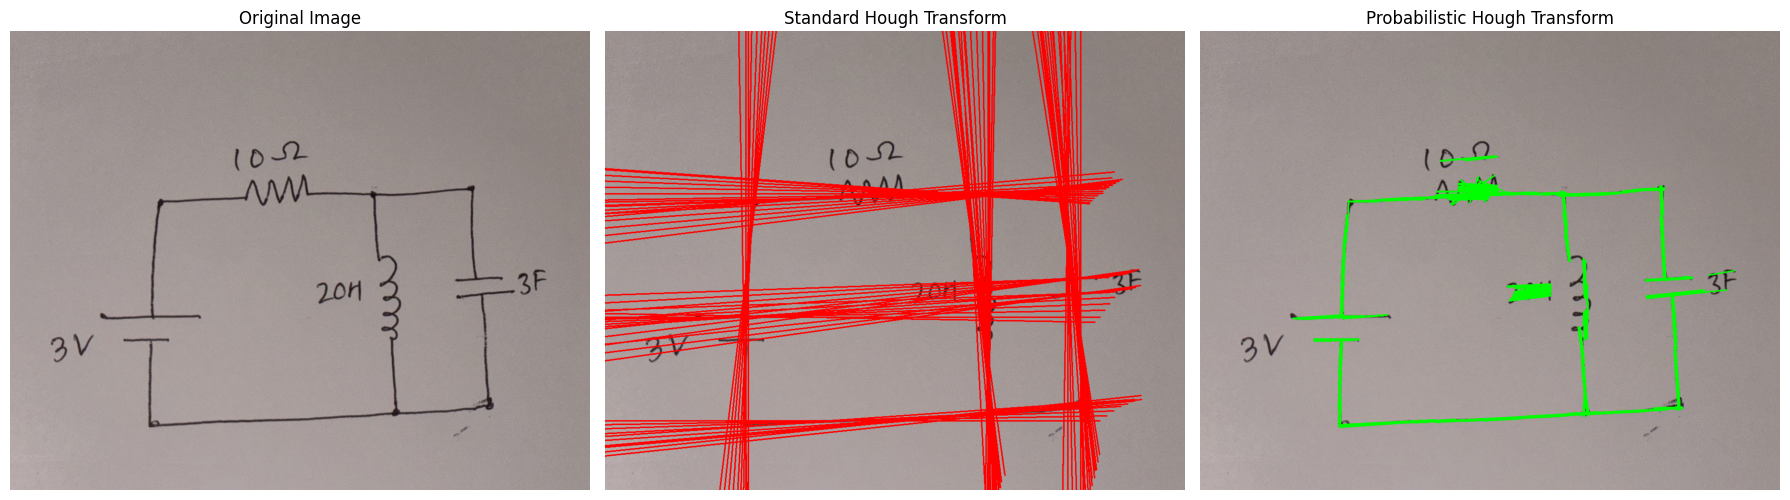

In [20]:

import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv

# --- Assuming 'invertedopened' and 'testimage2.png' exist from your setup ---

# --- Standard Hough Line Transform (unchanged) ---
hough_lines = cv.HoughLines(invertedopened, 1, np.pi / 180, 150)
hough_image = cv.imread('Imgtotest.jpg')
if hough_lines is not None:
    for line in hough_lines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv.line(hough_image, pt1, pt2, (0,0,255), 2)

# --- Probabilistic Hough Line Transform ---
prob_hough_image = cv.imread('Imgtotest.jpg')
prob_lines = cv.HoughLinesP(invertedopened, 1, np.pi / 180, 50, minLineLength=50, maxLineGap=20)

if prob_lines is not None:
    # --- ADD THIS ---
    # Open the text file in 'write' mode ('w')
    with open('hough_line.txt', 'w') as f:
        print("Writing endpoints to hough_line.txt...")
        for line in prob_lines:
            x1, y1, x2, y2 = line[0]
            cv.line(prob_hough_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
            # --- ADD THIS ---
            # Write the coordinates to the file
            f.write(f"({x1}, {y1}) to ({x2}, {y2})\n")

# --- Visualization (unchanged) ---
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(cv.cvtColor(cv.imread('Imgtotest.jpg'), cv.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cv.cvtColor(hough_image, cv.COLOR_BGR2RGB))
plt.title('Standard Hough Transform')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv.cvtColor(prob_hough_image, cv.COLOR_BGR2RGB))
plt.title('Probabilistic Hough Transform')
plt.axis('off')

plt.tight_layout()
plt.show()

In [2]:
import numpy as np
import cv2 as cv
from collections import deque, defaultdict
import math

# Complete class mapping
CLASS_NAMES = {
    0: 'text', 1: 'junction', 2: 'crossover', 3: 'terminal', 4: 'gnd',
    5: 'vss', 6: 'voltage.dc', 7: 'voltage.ac', 8: 'voltage.battery',
    9: 'resistor', 10: 'resistor.adjustable', 11: 'resistor.photo',
    12: 'capacitor.unpolarized', 13: 'capacitor.polarized', 14: 'capacitor.adjustable',
    15: 'inductor', 16: 'inductor.ferrite', 17: 'inductor.coupled',
    18: 'transformer', 19: 'diode', 20: 'diode.light_emitting',
    21: 'diode.thyrector', 22: 'diode.zener', 23: 'diac', 24: 'triac',
    25: 'thyristor', 26: 'varistor', 27: 'transistor.bjt', 28: 'transistor.fet',
    29: 'transistor.photo', 30: 'operational_amplifier', 
    31: 'operational_amplifier.schmitt_trigger', 32: 'optocoupler',
    33: 'integrated_circuit', 34: 'integrated_circuit.ne555',
    35: 'integrated_circuit.voltage_regulator', 36: 'xor', 37: 'and',
    38: 'or', 39: 'not', 40: 'nand', 41: 'nor', 42: 'probe',
    43: 'probe.current', 44: 'probe.voltage', 45: 'switch', 46: 'relay',
    47: 'socket', 48: 'fuse', 49: 'speaker', 50: 'motor', 51: 'lamp',
    52: 'microphone', 53: 'antenna', 54: 'crystal', 55: 'magnetic',
    56: 'mechanical', 57: 'block', 58: 'explanatory', 59: 'unknown'
}


class WirePathFinder:
    """
    Find wire connections between junctions and components using
    binary thresholded image path tracing.
    """
    
    def __init__(self, binary_image, detections):
        """
        Initialize the path finder.
        
        Args:
            binary_image: 2D numpy array (H, W) with 255 for wires, 0 for background
            detections: List of [class_id, cx, cy, w, h, conf] (normalized 0-1)
        """
        self.binary_image = binary_image
        self.img_h, self.img_w = binary_image.shape
        
        print(f"Binary Image Shape: {binary_image.shape}")
        print(f"Image dimensions: {self.img_w}x{self.img_h}")
        print(f"White pixels (wires): {np.sum(binary_image > 0)}")
        print(f"Black pixels (background): {np.sum(binary_image == 0)}")
        
        # Parse detections
        self.objects = []
        self.junctions = []
        
        for i, det in enumerate(detections):
            class_id, cx, cy, w, h, conf = det
            
            # Denormalize coordinates to pixel space
            cx_px = int(cx * self.img_w)
            cy_px = int(cy * self.img_h)
            w_px = int(w * self.img_w)
            h_px = int(h * self.img_h)
            
            obj = {
                'id': i,
                'class_id': int(class_id),
                'class_name': CLASS_NAMES.get(int(class_id), f'class_{int(class_id)}'),
                'center_norm': (cx, cy),
                'center_px': (cx_px, cy_px),
                'bbox_px': (cx_px, cy_px, w_px, h_px),
                'confidence': conf
            }
            
            self.objects.append(obj)
            
            if int(class_id) == 1:  # Junction
                self.junctions.append(obj)
        
        print(f"\nParsed {len(self.objects)} objects:")
        print(f"  Junctions: {len(self.junctions)}")
        print(f"  Other components: {len(self.objects) - len(self.junctions)}")
    
    def get_bbox_edges(self, obj, num_samples=12):
        """
        Get edge points of an object's bounding box.
        Returns points on all 4 edges for connection detection.
        """
        cx, cy, w, h = obj['bbox_px']
        x1, y1 = cx - w//2, cy - h//2
        x2, y2 = cx + w//2, cy + h//2
        
        edges = []
        
        # Sample points on each edge
        step = max(1, max(w, h) // num_samples)
        
        # Top edge
        for x in range(x1, x2+1, step):
            if 0 <= x < self.img_w and 0 <= y1 < self.img_h:
                edges.append((x, y1))
        
        # Bottom edge
        for x in range(x1, x2+1, step):
            if 0 <= x < self.img_w and 0 <= y2 < self.img_h:
                edges.append((x, y2))
        
        # Left edge
        for y in range(y1, y2+1, step):
            if 0 <= x1 < self.img_w and 0 <= y < self.img_h:
                edges.append((x1, y))
        
        # Right edge
        for y in range(y1, y2+1, step):
            if 0 <= x2 < self.img_w and 0 <= y < self.img_h:
                edges.append((x2, y))
        
        # Also add center point
        if 0 <= cx < self.img_w and 0 <= cy < self.img_h:
            edges.append((cx, cy))
        
        return edges
    
    def bfs_path_exists(self, start_px, end_px, max_path_length=1000):
        """
        Use BFS to check if a wire path exists between two points.
        
        Args:
            start_px: Starting pixel (x, y)
            end_px: Ending pixel (x, y)
            max_path_length: Maximum path length to search
        
        Returns:
            (path_exists, path_length, path_points)
        """
        if not (0 <= start_px[0] < self.img_w and 0 <= start_px[1] < self.img_h):
            return False, float('inf'), []
        
        if not (0 <= end_px[0] < self.img_w and 0 <= end_px[1] < self.img_h):
            return False, float('inf'), []
        
        # Find nearest wire pixels if start/end aren't on wires
        start_px = self._find_nearest_wire(start_px, radius=30)
        if start_px is None:
            return False, float('inf'), []
        
        end_px = self._find_nearest_wire(end_px, radius=30)
        if end_px is None:
            return False, float('inf'), []
        
        queue = deque([(start_px, [start_px])])
        visited = {start_px}
        
        # 8-connectivity for wire tracing
        directions = [(-1,-1), (-1,0), (-1,1), (0,-1), (0,1), (1,-1), (1,0), (1,1)]
        
        while queue:
            (x, y), path = queue.popleft()
            
            if len(path) > max_path_length:
                continue
            
            # Check if we reached the target (with small tolerance)
            if abs(x - end_px[0]) <= 5 and abs(y - end_px[1]) <= 5:
                return True, len(path), path
            
            # Explore neighbors
            for dx, dy in directions:
                nx, ny = x + dx, y + dy
                
                if (nx, ny) in visited:
                    continue
                
                if not (0 <= nx < self.img_w and 0 <= ny < self.img_h):
                    continue
                
                # Must be on wire (white pixel)
                if self.binary_image[ny, nx] > 0:
                    visited.add((nx, ny))
                    queue.append(((nx, ny), path + [(nx, ny)]))
        
        return False, float('inf'), []
    
    def _find_nearest_wire(self, point, radius=30):
        """Find nearest white pixel (wire) within radius."""
        x, y = point
        
        # Check if already on wire
        if 0 <= x < self.img_w and 0 <= y < self.img_h:
            if self.binary_image[y, x] > 0:
                return (x, y)
        
        # Search in expanding circles
        for r in range(1, radius+1):
            for angle in np.linspace(0, 2*np.pi, 8*r):
                nx = int(x + r * np.cos(angle))
                ny = int(y + r * np.sin(angle))
                
                if not (0 <= nx < self.img_w and 0 <= ny < self.img_h):
                    continue
                
                if self.binary_image[ny, nx] > 0:
                    return (nx, ny)
        
        return None
    
    def find_all_connections(self, max_direct_distance=0.4, max_path_length=1000):
        """
        Find all connections from junctions to other objects using wire tracing.
        
        Args:
            max_direct_distance: Max normalized distance for initial candidate filtering
            max_path_length: Maximum wire path length in pixels
        
        Returns:
            Dictionary mapping junction_id to list of connections
        """
        connections = defaultdict(list)
        
        print(f"\nSearching for connections from {len(self.junctions)} junctions...")
        
        for idx, junction in enumerate(self.junctions):
            j_id = junction['id']
            j_center_norm = junction['center_norm']
            j_center_px = junction['center_px']
            
            print(f"\nProcessing Junction {j_id} ({idx+1}/{len(self.junctions)})...")
            
            # Get junction edge points
            j_edges = self.get_bbox_edges(junction)
            
            for target in self.objects:
                if target['id'] == j_id:
                    continue
                
                # Skip text objects (class 0)
                if target['class_id'] == 0:
                    continue
                
                # Quick distance filter (normalized coordinates)
                dist_norm = math.sqrt(
                    (j_center_norm[0] - target['center_norm'][0])**2 +
                    (j_center_norm[1] - target['center_norm'][1])**2
                )
                
                if dist_norm > max_direct_distance:
                    continue
                
                # Get target edge points
                t_edges = self.get_bbox_edges(target)
                
                # Try to find wire path between junction and target edges
                path_found = False
                best_path_length = float('inf')
                best_path = []
                
                # Sample a subset of edge combinations for efficiency
                for j_edge in j_edges[::2]:  # Sample every 2nd edge point
                    if path_found and best_path_length < 100:
                        break  # Found short path, stop searching
                    
                    for t_edge in t_edges[::2]:
                        exists, length, path = self.bfs_path_exists(
                            j_edge, t_edge, max_path_length=max_path_length
                        )
                        
                        if exists and length < best_path_length:
                            path_found = True
                            best_path_length = length
                            best_path = path
                            
                            if length < 50:  # Very short path, likely good
                                break
                
                if path_found:
                    print(f"  Found connection to {target['class_name']} (ID: {target['id']}) - path: {best_path_length}px")
                    
                    connections[j_id].append({
                        'to_id': target['id'],
                        'to_class': target['class_name'],
                        'to_center': target['center_norm'],
                        'distance_norm': dist_norm,
                        'path_length_px': best_path_length,
                        'path_points': best_path[:100],  # Store first 100 points
                        'confidence': target['confidence']
                    })
        
        return connections
    
    def print_connections(self, connections):
        """Print connections in readable format."""
        print("\n" + "=" * 80)
        print("CIRCUIT CONNECTIONS FROM JUNCTIONS")
        print("=" * 80)
        
        if not connections:
            print("\nNo connections found!")
            return
        
        total_connections = sum(len(conns) for conns in connections.values())
        print(f"\nTotal Junctions with connections: {len(connections)}")
        print(f"Total Connections found: {total_connections}")
        if connections:
            print(f"Average Connections per Junction: {total_connections/len(connections):.2f}")
        
        for j_id, conns in sorted(connections.items()):
            junction = next(j for j in self.junctions if j['id'] == j_id)
            
            print(f"\n{'='*80}")
            print(f"Junction {j_id} at ({junction['center_norm'][0]:.3f}, {junction['center_norm'][1]:.3f})")
            print(f"Pixel location: ({junction['center_px'][0]}, {junction['center_px'][1]})")
            print(f"Confidence: {junction['confidence']:.2%}")
            print(f"Connected to {len(conns)} component(s):")
            
            for i, conn in enumerate(sorted(conns, key=lambda x: x['path_length_px']), 1):
                print(f"\n  {i}. {conn['to_class']} (ID: {conn['to_id']})")
                print(f"     Location: ({conn['to_center'][0]:.3f}, {conn['to_center'][1]:.3f})")
                print(f"     Direct distance: {conn['distance_norm']:.4f}")
                print(f"     Wire path length: {conn['path_length_px']:.1f} pixels")
                print(f"     Component confidence: {conn['confidence']:.2%}")
    
    def get_netlist(self, connections):
        """
        Generate a netlist representation of the circuit.
        
        Returns:
            List of nets, where each net is a list of connected component IDs
        """
        # Build adjacency graph
        graph = defaultdict(set)
        
        for j_id, conns in connections.items():
            for conn in conns:
                graph[j_id].add(conn['to_id'])
                graph[conn['to_id']].add(j_id)
        
        # Find connected components (nets) using DFS
        visited = set()
        nets = []
        
        def dfs(node, net):
            if node in visited:
                return
            visited.add(node)
            net.append(node)
            
            for neighbor in graph[node]:
                dfs(neighbor, net)
        
        for obj in self.objects:
            if obj['id'] not in visited and obj['class_id'] != 0:  # Skip text
                net = []
                dfs(obj['id'], net)
                if len(net) > 1:  # Only include connected nets
                    nets.append(net)
        
        return nets
    
    def print_netlist(self, nets):
        """Print netlist in readable format."""
        print("\n" + "="*80)
        print("NETLIST (Connected Components)")
        print("="*80)
        
        if not nets:
            print("\nNo connected nets found!")
            return
        
        for i, net in enumerate(nets, 1):
            print(f"\nNet {i}: {len(net)} components connected")
            
            net_components = []
            for obj_id in net:
                obj = next(o for o in self.objects if o['id'] == obj_id)
                net_components.append(f"{obj['class_name']}_{obj_id}")
            
            print(f"  Components: {', '.join(net_components)}")


def load_detections(txt_file):
    """Load YOLO detections from text file."""
    detections = []
    with open(txt_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 6:
                detection = [float(x) for x in parts]
                detections.append(detection)
    return detections


# Main execution
if __name__ == "__main__":
    print("CIRCUIT WIRE PATH FINDER")
    print("="*80)
    
    # File paths
    binary_image_path = "Imgtotest.jpg"
    detections_file = "Imgtotest.txt"
    
    # Load binary thresholded image
    print(f"\nLoading binary image from: {binary_image_path}")
    binary_img = cv.imread(binary_image_path, cv.IMREAD_GRAYSCALE)
    ret_otsu, binary_img = cv.threshold(binary_img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    binary_img = cv.bitwise_not(binary_img)
    if binary_img is None:
        print(f"Error: Could not load image from {binary_image_path}")
        exit(1)
    
    print(f"Image loaded successfully: {binary_img.shape}")
    
    # Load detections
    print(f"\nLoading detections from: {detections_file}")
    detections = load_detections(detections_file)
    print(f"Loaded {len(detections)} detections")
    
    # Initialize path finder
    finder = WirePathFinder(binary_img, detections)
    
    # Find connections with wire path verification
    print("\n" + "="*80)
    print("FINDING WIRE CONNECTIONS...")
    print("="*80)
    
    connections = finder.find_all_connections(
        max_direct_distance=0.4,  # Only check objects within 40% of image
        max_path_length=1000      # Max 1000 pixel wire path
    )
    
    # Print results
    finder.print_connections(connections)
    
    # Generate and print netlist
    nets = finder.get_netlist(connections)
    finder.print_netlist(nets)
    
    print("\n" + "="*80)
    print("DONE!")
    print("="*80)

CIRCUIT WIRE PATH FINDER

Loading binary image from: Imgtotest.jpg
Image loaded successfully: (926, 1171)

Loading detections from: Imgtotest.txt
Loaded 14 detections
Binary Image Shape: (926, 1171)
Image dimensions: 1171x926
White pixels (wires): 21340
Black pixels (background): 1063006

Parsed 14 objects:
  Junctions: 6
  Other components: 8

FINDING WIRE CONNECTIONS...

Searching for connections from 6 junctions...

Processing Junction 0 (1/6)...
  Found connection to junction (ID: 5) - path: 148px
  Found connection to junction (ID: 5) - path: 148px
  Found connection to inductor (ID: 8) - path: 122px
  Found connection to inductor (ID: 8) - path: 122px
  Found connection to capacitor.unpolarized (ID: 9) - path: 372px

Processing Junction 1 (2/6)...
  Found connection to capacitor.unpolarized (ID: 9) - path: 372px

Processing Junction 1 (2/6)...
  Found connection to junction (ID: 2) - path: 161px
  Found connection to junction (ID: 2) - path: 161px
  Found connection to resistor (

In [3]:
import numpy as np
import cv2 as cv
from collections import deque, defaultdict
import math

# Complete class mapping
CLASS_NAMES = {
    0: 'text', 1: 'junction', 2: 'crossover', 3: 'terminal', 4: 'gnd',
    5: 'vss', 6: 'voltage.dc', 7: 'voltage.ac', 8: 'voltage.battery',
    9: 'resistor', 10: 'resistor.adjustable', 11: 'resistor.photo',
    12: 'capacitor.unpolarized', 13: 'capacitor.polarized', 14: 'capacitor.adjustable',
    15: 'inductor', 16: 'inductor.ferrite', 17: 'inductor.coupled',
    18: 'transformer', 19: 'diode', 20: 'diode.light_emitting',
    21: 'diode.thyrector', 22: 'diode.zener', 23: 'diac', 24: 'triac',
    25: 'thyristor', 26: 'varistor', 27: 'transistor.bjt', 28: 'transistor.fet',
    29: 'transistor.photo', 30: 'operational_amplifier', 
    31: 'operational_amplifier.schmitt_trigger', 32: 'optocoupler',
    33: 'integrated_circuit', 34: 'integrated_circuit.ne555',
    35: 'integrated_circuit.voltage_regulator', 36: 'xor', 37: 'and',
    38: 'or', 39: 'not', 40: 'nand', 41: 'nor', 42: 'probe',
    43: 'probe.current', 44: 'probe.voltage', 45: 'switch', 46: 'relay',
    47: 'socket', 48: 'fuse', 49: 'speaker', 50: 'motor', 51: 'lamp',
    52: 'microphone', 53: 'antenna', 54: 'crystal', 55: 'magnetic',
    56: 'mechanical', 57: 'block', 58: 'explanatory', 59: 'unknown'
}


class WirePathFinder:
    """
    Find wire connections between junctions and components using
    binary thresholded image path tracing.
    """
    
    def __init__(self, binary_image, detections):
        """
        Initialize the path finder.
        
        Args:
            binary_image: 2D numpy array (H, W) with 255 for wires, 0 for background
            detections: List of [class_id, cx, cy, w, h, conf] (normalized 0-1)
        """
        self.binary_image = binary_image
        self.img_h, self.img_w = binary_image.shape
        
        print(f"Binary Image Shape: {binary_image.shape}")
        print(f"Image dimensions: {self.img_w}x{self.img_h}")
        print(f"White pixels (wires): {np.sum(binary_image > 0)}")
        print(f"Black pixels (background): {np.sum(binary_image == 0)}")
        
        # Parse detections
        self.objects = []
        self.junctions = []
        
        for i, det in enumerate(detections):
            class_id, cx, cy, w, h, conf = det
            
            # Denormalize coordinates to pixel space
            cx_px = int(cx * self.img_w)
            cy_px = int(cy * self.img_h)
            w_px = int(w * self.img_w)
            h_px = int(h * self.img_h)
            
            obj = {
                'id': i,
                'class_id': int(class_id),
                'class_name': CLASS_NAMES.get(int(class_id), f'class_{int(class_id)}'),
                'center_norm': (cx, cy),
                'center_px': (cx_px, cy_px),
                'bbox_px': (cx_px, cy_px, w_px, h_px),
                'confidence': conf
            }
            
            self.objects.append(obj)
            
            if int(class_id) == 1:  # Junction
                self.junctions.append(obj)
        
        print(f"\nParsed {len(self.objects)} objects:")
        print(f"  Junctions: {len(self.junctions)}")
        print(f"  Other components: {len(self.objects) - len(self.junctions)}")
    
    def get_bbox_edges(self, obj, num_samples=12):
        """
        Get edge points of an object's bounding box.
        Returns points on all 4 edges for connection detection.
        """
        cx, cy, w, h = obj['bbox_px']
        x1, y1 = cx - w//2, cy - h//2
        x2, y2 = cx + w//2, cy + h//2
        
        edges = []
        
        # Sample points on each edge
        step = max(1, max(w, h) // num_samples)
        
        # Top edge
        for x in range(x1, x2+1, step):
            if 0 <= x < self.img_w and 0 <= y1 < self.img_h:
                edges.append((x, y1))
        
        # Bottom edge
        for x in range(x1, x2+1, step):
            if 0 <= x < self.img_w and 0 <= y2 < self.img_h:
                edges.append((x, y2))
        
        # Left edge
        for y in range(y1, y2+1, step):
            if 0 <= x1 < self.img_w and 0 <= y < self.img_h:
                edges.append((x1, y))
        
        # Right edge
        for y in range(y1, y2+1, step):
            if 0 <= x2 < self.img_w and 0 <= y < self.img_h:
                edges.append((x2, y))
        
        # Also add center point
        if 0 <= cx < self.img_w and 0 <= cy < self.img_h:
            edges.append((cx, cy))
        
        return edges
    
    def bfs_find_all_connections(self, start_px, target_objects, max_path_length=1000):
        """
        Use BFS to find all components reachable from a starting point.
        Each path stops when it reaches a component, but search continues for other paths.
        
        Args:
            start_px: Starting pixel (x, y)
            target_objects: List of target objects to find
            max_path_length: Maximum path length to search
        
        Returns:
            List of (object_id, path_length, path_points) for each found connection
        """
        if not (0 <= start_px[0] < self.img_w and 0 <= start_px[1] < self.img_h):
            return []
        
        # Find nearest wire pixel if start isn't on wire
        start_px = self._find_nearest_wire(start_px, radius=30)
        if start_px is None:
            return []
        
        # Build lookup of target regions (expanded bounding boxes)
        target_regions = {}
        for target in target_objects:
            cx, cy, w, h = target['bbox_px']
            x1, y1 = cx - w//2 - 5, cy - h//2 - 5
            x2, y2 = cx + w//2 + 5, cy + h//2 + 5
            target_regions[target['id']] = (x1, y1, x2, y2, target)
        
        queue = deque([(start_px, [start_px], set())])  # (position, path, found_objects)
        visited = {start_px}
        connections = []
        found_objects = set()
        
        # 8-connectivity for wire tracing
        directions = [(-1,-1), (-1,0), (-1,1), (0,-1), (0,1), (1,-1), (1,0), (1,1)]
        
        while queue:
            (x, y), path, path_found = queue.popleft()
            
            if len(path) > max_path_length:
                continue
            
            # Check if current position intersects any target component
            component_hit = None
            for obj_id, (x1, y1, x2, y2, target) in target_regions.items():
                if obj_id in path_found:
                    continue  # Already found in this path
                
                if x1 <= x <= x2 and y1 <= y <= y2:
                    component_hit = target
                    break
            
            # If we hit a component, record it and stop THIS path (but continue search)
            if component_hit is not None:
                if component_hit['id'] not in found_objects:
                    connections.append({
                        'object': component_hit,
                        'path_length': len(path),
                        'path_points': path
                    })
                    found_objects.add(component_hit['id'])
                # Don't explore further from this path
                continue
            
            # Explore neighbors (only if we haven't hit a component)
            for dx, dy in directions:
                nx, ny = x + dx, y + dy
                
                if (nx, ny) in visited:
                    continue
                
                if not (0 <= nx < self.img_w and 0 <= ny < self.img_h):
                    continue
                
                # Must be on wire (white pixel)
                if self.binary_image[ny, nx] > 0:
                    visited.add((nx, ny))
                    queue.append(((nx, ny), path + [(nx, ny)], path_found.copy()))
        
        return connections
    
    def _find_nearest_wire(self, point, radius=30):
        """Find nearest white pixel (wire) within radius."""
        x, y = point
        
        # Check if already on wire
        if 0 <= x < self.img_w and 0 <= y < self.img_h:
            if self.binary_image[y, x] > 0:
                return (x, y)
        
        # Search in expanding circles
        for r in range(1, radius+1):
            for angle in np.linspace(0, 2*np.pi, 8*r):
                nx = int(x + r * np.cos(angle))
                ny = int(y + r * np.sin(angle))
                
                if not (0 <= nx < self.img_w and 0 <= ny < self.img_h):
                    continue
                
                if self.binary_image[ny, nx] > 0:
                    return (nx, ny)
        
        return None
    
    def find_all_connections(self, max_direct_distance=0.4, max_path_length=1000):
        """
        Find all connections from junctions to other objects using wire tracing.
        Each path stops when reaching a component, but search continues for other paths.
        
        Args:
            max_direct_distance: Max normalized distance for initial candidate filtering
            max_path_length: Maximum wire path length in pixels
        
        Returns:
            Dictionary mapping junction_id to list of connections
        """
        connections = defaultdict(list)
        
        print(f"\nSearching for connections from {len(self.junctions)} junctions...")
        
        for idx, junction in enumerate(self.junctions):
            j_id = junction['id']
            j_center_norm = junction['center_norm']
            
            print(f"\nProcessing Junction {j_id} ({idx+1}/{len(self.junctions)})...")
            
            # Filter potential targets by distance
            target_objects = []
            for target in self.objects:
                if target['id'] == j_id:
                    continue
                
                # Skip text objects (class 0)
                if target['class_id'] == 0:
                    continue
                
                # Quick distance filter (normalized coordinates)
                dist_norm = math.sqrt(
                    (j_center_norm[0] - target['center_norm'][0])**2 +
                    (j_center_norm[1] - target['center_norm'][1])**2
                )
                
                if dist_norm <= max_direct_distance:
                    target_objects.append(target)
            
            print(f"  Found {len(target_objects)} potential targets within range")
            
            # Get junction edge points as starting points
            j_edges = self.get_bbox_edges(junction)
            
            # Try BFS from multiple edge points to find all reachable components
            all_found = {}  # object_id -> best connection
            
            for j_edge in j_edges[::3]:  # Sample every 3rd edge point for efficiency
                # Run BFS from this edge point to find all reachable components
                found_connections = self.bfs_find_all_connections(
                    j_edge, 
                    target_objects, 
                    max_path_length=max_path_length
                )
                
                # Update best paths for each found component
                for conn in found_connections:
                    obj_id = conn['object']['id']
                    path_len = conn['path_length']
                    
                    if obj_id not in all_found or path_len < all_found[obj_id]['path_length']:
                        all_found[obj_id] = conn
            
            # Add all found connections
            for obj_id, conn in all_found.items():
                target = conn['object']
                path_len = conn['path_length']
                
                dist_norm = math.sqrt(
                    (j_center_norm[0] - target['center_norm'][0])**2 +
                    (j_center_norm[1] - target['center_norm'][1])**2
                )
                
                print(f"  Found connection to {target['class_name']} (ID: {target['id']}) - path: {path_len}px")
                
                connections[j_id].append({
                    'to_id': target['id'],
                    'to_class': target['class_name'],
                    'to_center': target['center_norm'],
                    'distance_norm': dist_norm,
                    'path_length_px': path_len,
                    'path_points': conn['path_points'][:100],  # Store first 100 points
                    'confidence': target['confidence']
                })
        
        return connections
    
    def print_connections(self, connections):
        """Print connections in readable format."""
        print("\n" + "=" * 80)
        print("CIRCUIT CONNECTIONS FROM JUNCTIONS")
        print("=" * 80)
        
        if not connections:
            print("\nNo connections found!")
            return
        
        total_connections = sum(len(conns) for conns in connections.values())
        print(f"\nTotal Junctions with connections: {len(connections)}")
        print(f"Total Connections found: {total_connections}")
        if connections:
            print(f"Average Connections per Junction: {total_connections/len(connections):.2f}")
        
        for j_id, conns in sorted(connections.items()):
            junction = next(j for j in self.junctions if j['id'] == j_id)
            
            print(f"\n{'='*80}")
            print(f"Junction {j_id} at ({junction['center_norm'][0]:.3f}, {junction['center_norm'][1]:.3f})")
            print(f"Pixel location: ({junction['center_px'][0]}, {junction['center_px'][1]})")
            print(f"Confidence: {junction['confidence']:.2%}")
            print(f"Connected to {len(conns)} component(s):")
            
            for i, conn in enumerate(sorted(conns, key=lambda x: x['path_length_px']), 1):
                print(f"\n  {i}. {conn['to_class']} (ID: {conn['to_id']})")
                print(f"     Location: ({conn['to_center'][0]:.3f}, {conn['to_center'][1]:.3f})")
                print(f"     Direct distance: {conn['distance_norm']:.4f}")
                print(f"     Wire path length: {conn['path_length_px']:.1f} pixels")
                print(f"     Component confidence: {conn['confidence']:.2%}")
    
    def get_netlist(self, connections):
        """
        Generate a netlist representation of the circuit.
        
        Returns:
            List of nets, where each net is a list of connected component IDs
        """
        # Build adjacency graph
        graph = defaultdict(set)
        
        for j_id, conns in connections.items():
            for conn in conns:
                graph[j_id].add(conn['to_id'])
                graph[conn['to_id']].add(j_id)
        
        # Find connected components (nets) using DFS
        visited = set()
        nets = []
        
        def dfs(node, net):
            if node in visited:
                return
            visited.add(node)
            net.append(node)
            
            for neighbor in graph[node]:
                dfs(neighbor, net)
        
        for obj in self.objects:
            if obj['id'] not in visited and obj['class_id'] != 0:  # Skip text
                net = []
                dfs(obj['id'], net)
                if len(net) > 1:  # Only include connected nets
                    nets.append(net)
        
        return nets
    
    def print_netlist(self, nets):
        """Print netlist in readable format."""
        print("\n" + "="*80)
        print("NETLIST (Connected Components)")
        print("="*80)
        
        if not nets:
            print("\nNo connected nets found!")
            return
        
        for i, net in enumerate(nets, 1):
            print(f"\nNet {i}: {len(net)} components connected")
            
            net_components = []
            for obj_id in net:
                obj = next(o for o in self.objects if o['id'] == obj_id)
                net_components.append(f"{obj['class_name']}_{obj_id}")
            
            print(f"  Components: {', '.join(net_components)}")


def load_detections(txt_file):
    """Load YOLO detections from text file."""
    detections = []
    with open(txt_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 6:
                detection = [float(x) for x in parts]
                detections.append(detection)
    return detections


# Main execution
if __name__ == "__main__":
    print("CIRCUIT WIRE PATH FINDER")
    print("="*80)
    
    # File paths
    binary_image_path = "Imgtotest.jpg"
    detections_file = "Imgtotest.txt"
    
    # Load binary thresholded image
    print(f"\nLoading binary image from: {binary_image_path}")
    binary_img = cv.imread(binary_image_path, cv.IMREAD_GRAYSCALE)
    ret_otsu, binary_img = cv.threshold(binary_img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    binary_img = cv.bitwise_not(binary_img)
    
    if binary_img is None:
        print(f"Error: Could not load image from {binary_image_path}")
        exit(1)
    
    print(f"Image loaded successfully: {binary_img.shape}")
    
    # Load detections
    print(f"\nLoading detections from: {detections_file}")
    detections = load_detections(detections_file)
    print(f"Loaded {len(detections)} detections")
    
    # Initialize path finder
    finder = WirePathFinder(binary_img, detections)
    
    # Find connections with wire path verification
    print("\n" + "="*80)
    print("FINDING WIRE CONNECTIONS...")
    print("="*80)
    
    connections = finder.find_all_connections(
        max_direct_distance=0.4,  # Only check objects within 40% of image
        max_path_length=1000      # Max 1000 pixel wire path
    )
    
    # Print results
    finder.print_connections(connections)
    
    # Generate and print netlist
    nets = finder.get_netlist(connections)
    finder.print_netlist(nets)
    
    print("\n" + "="*80)
    print("DONE!")
    print("="*80)

CIRCUIT WIRE PATH FINDER

Loading binary image from: Imgtotest.jpg
Image loaded successfully: (926, 1171)

Loading detections from: Imgtotest.txt
Loaded 14 detections
Binary Image Shape: (926, 1171)
Image dimensions: 1171x926
White pixels (wires): 21340
Black pixels (background): 1063006

Parsed 14 objects:
  Junctions: 6
  Other components: 8

FINDING WIRE CONNECTIONS...

Searching for connections from 6 junctions...

Processing Junction 0 (1/6)...
  Found 3 potential targets within range
  Found connection to inductor (ID: 8) - path: 119px
  Found connection to junction (ID: 5) - path: 151px

Processing Junction 1 (2/6)...
  Found 4 potential targets within range
  Found connection to capacitor.unpolarized (ID: 9) - path: 151px
  Found connection to junction (ID: 2) - path: 162px

Processing Junction 2 (3/6)...
  Found 5 potential targets within range
  Found connection to inductor (ID: 8) - path: 119px
  Found connection to junction (ID: 5) - path: 151px

Processing Junction 1 (2/6)

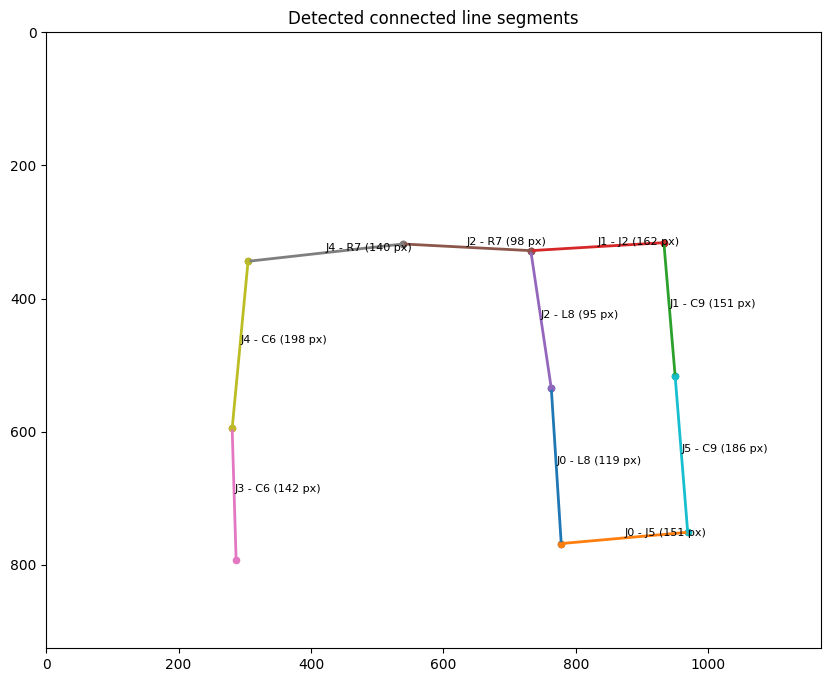

In [4]:
import matplotlib.pyplot as plt

# estimated image size
W, H = 1170.47, 925.28

# list of segments as ((x0,y0),(x1,y1), label)
segments = [
    ((778,768),(763,535),"J0 - L8 (119 px)"),
    ((778,768),(969,751),"J0 - J5 (151 px)"),
    ((933,316),(950,516),"J1 - C9 (151 px)"),
    ((933,316),(732,328),"J1 - J2 (162 px)"),
    ((732,328),(763,535),"J2 - L8 (95 px)"),
    ((732,328),(539,318),"J2 - R7 (98 px)"),
    ((287,793),(281,595),"J3 - C6 (142 px)"),
    ((305,344),(539,318),"J4 - R7 (140 px)"),
    ((305,344),(281,595),"J4 - C6 (198 px)"),
    ((969,751),(950,516),"J5 - C9 (186 px)"),
]

fig, ax = plt.subplots(figsize=(10,8))
# draw blank image extent
ax.set_xlim(0, W); ax.set_ylim(H, 0)  # y inverted so 0 is top like image
# optionally show the image:
# img = plt.imread("your_circuit_image.png")
# ax.imshow(img, extent=[0, W, H, 0])

for (x0,y0),(x1,y1),label in segments:
    ax.plot([x0,x1],[y0,y1], linewidth=2)
    ax.scatter([x0,x1],[y0,y1], s=20)
    # label midpoint
    mx, my = (x0+x1)/2, (y0+y1)/2
    ax.text(mx, my, label, fontsize=8, verticalalignment='bottom')

ax.set_title("Detected connected line segments")
plt.show()


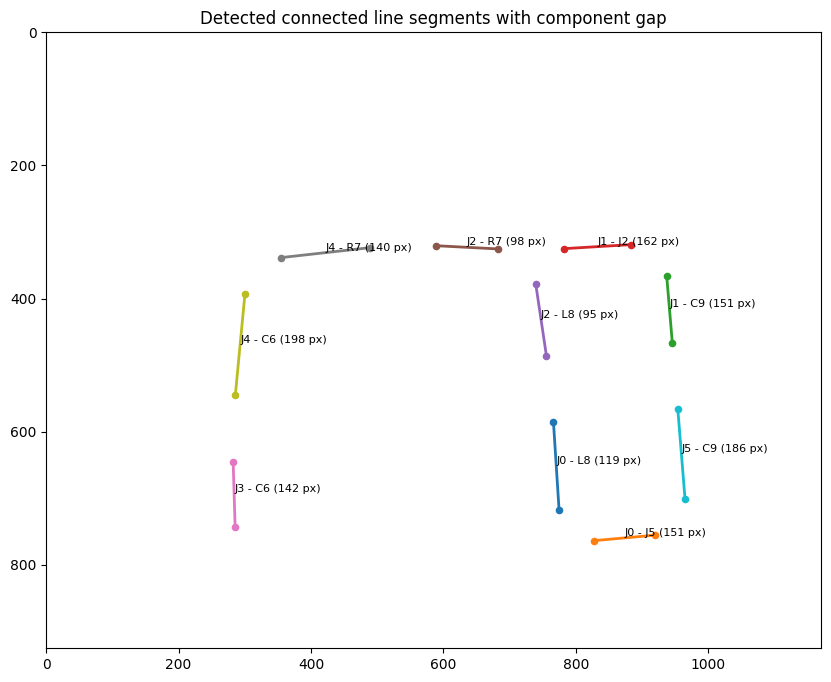

In [11]:
import matplotlib.pyplot as plt
import math

W, H = 1170.47, 925.28

segments = [
    ((778,768),(763,535),"J0 - L8 (119 px)"),
    ((778,768),(969,751),"J0 - J5 (151 px)"),
    ((933,316),(950,516),"J1 - C9 (151 px)"),
    ((933,316),(732,328),"J1 - J2 (162 px)"),
    ((732,328),(763,535),"J2 - L8 (95 px)"),
    ((732,328),(539,318),"J2 - R7 (98 px)"),
    ((287,793),(281,595),"J3 - C6 (142 px)"),
    ((305,344),(539,318),"J4 - R7 (140 px)"),
    ((305,344),(281,595),"J4 - C6 (198 px)"),
    ((969,751),(950,516),"J5 - C9 (186 px)"),
]

def shorten_segment(p0, p1, gap=150):
    # gap is total removed length, so half from each side
    g = gap / 2
    x0, y0 = p0
    x1, y1 = p1

    dx = x1 - x0
    dy = y1 - y0
    length = math.hypot(dx, dy)

    if length <= gap:
        return p0, p1  # do not invert if it is too short

    ux = dx / length
    uy = dy / length

    # move both points inward
    new_p0 = (x0 + ux * g, y0 + uy * g)
    new_p1 = (x1 - ux * g, y1 - uy * g)

    return new_p0, new_p1

fig, ax = plt.subplots(figsize=(10,8))
ax.set_xlim(0, W)
ax.set_ylim(H, 0)

for (x0,y0),(x1,y1),label in segments:
    (sx0, sy0), (sx1, sy1) = shorten_segment((x0,y0),(x1,y1), gap=100)

    ax.plot([sx0, sx1], [sy0, sy1], linewidth=2)
    ax.scatter([sx0, sx1], [sy0, sy1], s=20)

    mx, my = (sx0 + sx1)/2, (sy0 + sy1)/2
    ax.text(mx, my, label, fontsize=8, verticalalignment='bottom')

ax.set_title("Detected connected line segments with component gap")
plt.show()
